In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

builder = tfds.builder("cats_vs_dogs")
builder.download_and_prepare()

train_data = builder.as_dataset(split="train")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompletePOM4QG/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
for example in train_data.take(5):
    image = example["image"]
    label = example["label"]
    filename = example["image/filename"]
    print(f"Label: {label.numpy()}, Filename: {filename.numpy()}")

Label: 1, Filename: b'PetImages/Dog/10396.jpg'
Label: 1, Filename: b'PetImages/Dog/4077.jpg'
Label: 1, Filename: b'PetImages/Dog/10497.jpg'
Label: 0, Filename: b'PetImages/Cat/2763.jpg'
Label: 1, Filename: b'PetImages/Dog/11257.jpg'


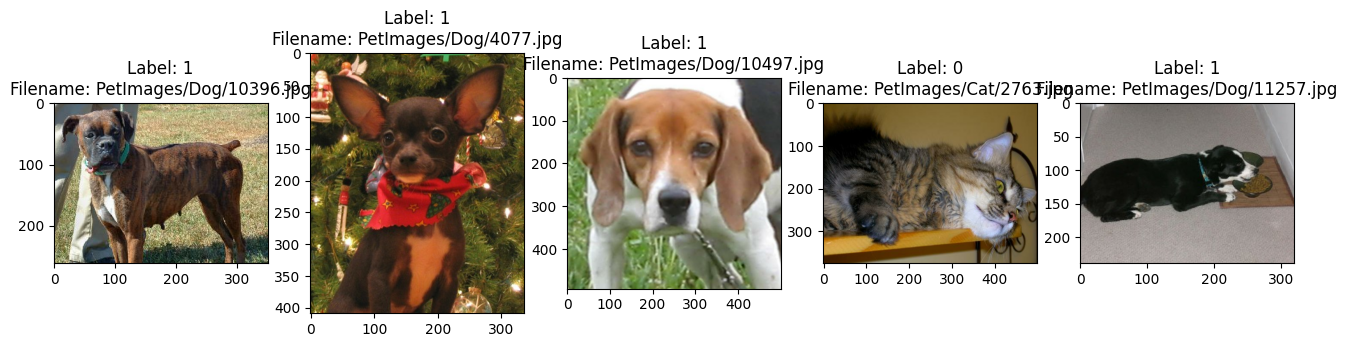

In [4]:
import matplotlib.pyplot as plt
train_data = builder.as_dataset(split="train")
sample_images = list(train_data.take(5))
fig, axs = plt.subplots(1, len(sample_images), figsize=(16, 4))

for i, example in enumerate(sample_images):
    image = example["image"].numpy()
    label = example["label"].numpy()
    filename = example["image/filename"].numpy().decode()

    axs[i].imshow(image)
    axs[i].set_title(f"Label: {label}\nFilename: {filename}")

plt.show()

In [5]:
def preprocess_data(data):
    def _preprocess(example):
        image = tf.image.resize(example["image"], (224, 224))
        image = tf.image.convert_image_dtype(image, tf.float32)
        label = tf.one_hot(example["label"], depth=2)
        return image, label

    data = data.map(_preprocess)
    data = data.batch(16)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [6]:
train_size = int(0.8 * builder.info.splits["train"].num_examples)
test_size = builder.info.splits["train"].num_examples - train_size

train_data = train_data.take(train_size)
test_data = train_data.skip(train_size).take(test_size)

In [7]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [8]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [9]:
for layer in resnet.layers:
    layer.trainable = False

In [10]:
x = Flatten()(resnet.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

In [11]:
model = Model(inputs=resnet.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_data, validation_data=test_data, epochs=10,verbose=1)
for epoch in range(0, 10):
    train_accuracy = history.history['accuracy'][epoch]

    print(f'Epoch {epoch + 1} - Training Accuracy: {train_accuracy:.4f}')

Epoch 1/10
1164/1164 [==============================] - 75s 54ms/step - loss: 0.2660 - accuracy: 0.9632
Epoch 2/10
1164/1164 [==============================] - 63s 54ms/step - loss: 0.0884 - accuracy: 0.9789
Epoch 3/10
1164/1164 [==============================] - 63s 54ms/step - loss: 0.0571 - accuracy: 0.9869
Epoch 4/10
1164/1164 [==============================] - 63s 54ms/step - loss: 0.0232 - accuracy: 0.9921
Epoch 5/10
1164/1164 [==============================] - 64s 55ms/step - loss: 0.0258 - accuracy: 0.9928
Epoch 6/10
1164/1164 [==============================] - 63s 54ms/step - loss: 0.0305 - accuracy: 0.9941
Epoch 7/10
1164/1164 [==============================] - 63s 54ms/step - loss: 0.0130 - accuracy: 0.9965
Epoch 8/10
1164/1164 [==============================] - 62s 54ms/step - loss: 0.0128 - accuracy: 0.9964
Epoch 9/10
1164/1164 [==============================] - 63s 54ms/step - loss: 0.0134 - accuracy: 0.9963
Epoch 10/10
1164/1164 [==============================] - 63s 54m